My first public Kaggle notebook. Using Recall and Precision to judge the predictions. Trying out some ideas for novelty / outlier detection. Implemented my own Multivariate Gaussian outlier detection function and compare to scikit OneClassSVM. 

I reach 97% recall with 0.01 precision. This corresponds to catching 97% of all frauds, but giving a false alert 99% of the time. Any feedback on this result is much appreciated.

Note: I don't think using accuracy as a measure of how well your prediction algorithm works is useful here. If we simply set all predicitons to "No Fraud", we obtain an accuracy of over 99%. For more information you can read this https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm

from sklearn.model_selection import train_test_split
import seaborn as sns

%matplotlib inline

In [121]:
#load data
data = pd.read_csv("../input/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [122]:
len(data['Class'][data.Class==1]), len(data['Class'][data.Class==0]), len(data)

(492, 284315, 284807)

In [123]:
len(data['Class'][data.Class==0]) + len(data['Class'][data.Class==1]) == len(data)

True

In [124]:
data.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,-1.040458,-0.031513,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


In [125]:
data.groupby(("Class")).mean()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,94838.202258,0.008258,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467,0.009824,-0.006576,0.010832,0.000189,0.012064,0.000161,0.007164,0.011535,0.003887,-0.001178,-0.000644,-0.001235,-0.000024,0.000070,0.000182,-0.000072,-0.000089,-0.000295,-0.000131,88.291022
1,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,-5.676883,3.800173,-6.259393,-0.109334,-6.971723,-0.092929,-4.139946,-6.665836,-2.246308,0.680659,0.372319,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321


In [126]:
def plot_decision_function(model, ax, sv=True):
    # mesh-grid to evaluate the model
    xx, yy = np.meshgrid(np.linspace(-4, 4, 100),
                         np.linspace(-4, 4, 100))
    # evaluating the model
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ## plots the margin
    ax = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
    ax = plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')
    
    ax = plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 6), cmap=plt.cm.PuBu)
    
    if sv:
        ax = plt.scatter(model.support_vectors_[:, 0],
                       model.support_vectors_[:, 1],
                       s=300, linewidth=1, facecolors='none', edgecolors='black')

In [127]:
def plot_new_observations(X_train, X_new, anomaly, ax):
    _ = plt.scatter(X_train[:,0], X_train[:,1],
                    axes=ax, color='w', s=40, edgecolors='k',
                    label='Training data')

    _ = plt.scatter(X_new[:,0], X_new[:,1], axes=ax,
                    color='violet', s=40, edgecolors='k',
                    label='New regular observations')

    _ = plt.scatter(anomaly[:,0], anomaly[:,1], axes=ax,
                    color='gold', s=40, edgecolors='k',
                    label='New abnormal observations')

    _ = ax.legend()
    _ = ax.set_xlim([-4, 4])
    _ = ax.set_ylim([-4, 4])

In [128]:
n_points = 200

In [129]:
## generate a cluster of points for the training 
np.random.seed(42)
X_train = 0.5 * np.random.randn(n_points, 2)

In [130]:
X_train.shape

(200, 2)

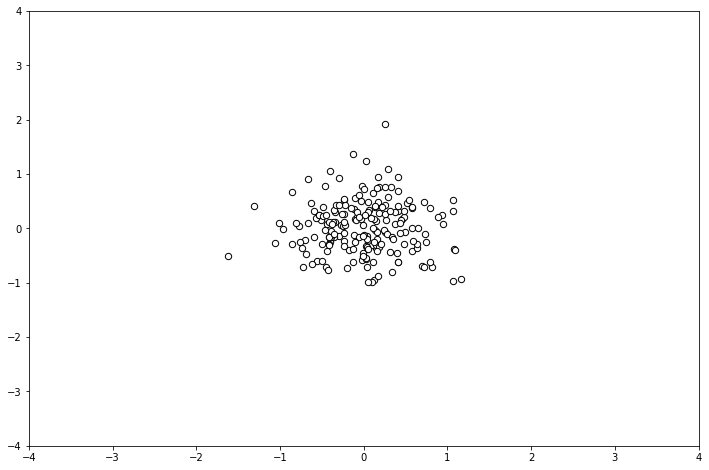

In [131]:
## plot
fig, ax = plt.subplots(figsize=(12,8))
_ = plt.scatter(X_train[:,0], X_train[:,1], axes=ax, color='w', s=40, edgecolors='k')
_ = ax.set_xlim([-4, 4])
_ = ax.set_ylim([-4, 4])

In [132]:
model = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.7)
model.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.7, kernel='rbf',
      max_iter=-1, nu=0.05, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

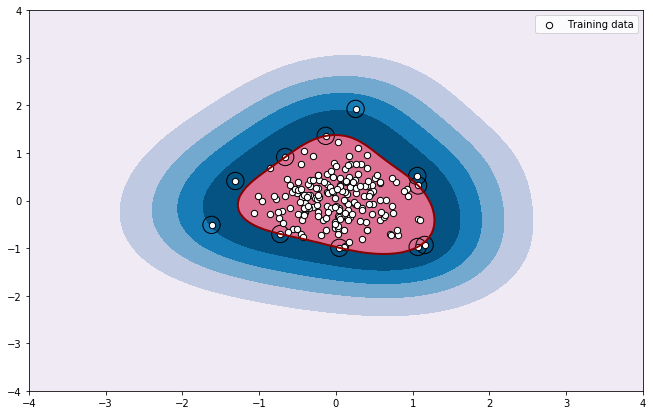

In [133]:
fig, ax = plt.subplots(figsize=(11,7))

# Plot the decision function
plot_decision_function(model, ax, sv=True)

# Add the training points
_ = plt.scatter(X_train[:,0], X_train[:,1], axes=ax,
                color='w', s=40, edgecolors='k',label='Training data')
_ = ax.legend()

In [134]:
# compute the empirical error 
y_train = model.predict(X_train)
err_emp_1 = y_train[y_train == -1].size
print("Training error = {}/{}".format(err_emp_1, n_points))

Training error = 8/200


In [135]:
# Reduce nu, i.e. weight more the slack variables
model = svm.OneClassSVM(nu=0.005, kernel="rbf", gamma=0.7)
model.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.7, kernel='rbf',
      max_iter=-1, nu=0.005, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

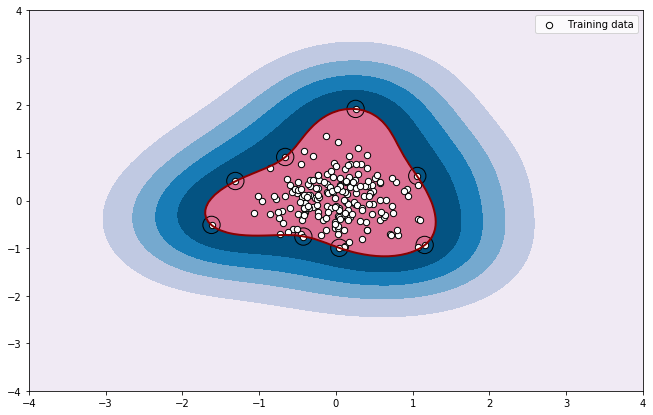

In [136]:
fig, ax = plt.subplots(figsize=(11,7))

# plot the decision function
plot_decision_function(model, ax, sv=True)

# add the training points
_ = plt.scatter(X_train[:,0], X_train[:,1], axes=ax,
                color='w', s=40, edgecolors='k',label='Training data')
_ = ax.legend()

In [137]:
# Compute the empirical error 
y_train = model.predict(X_train)
err_emp_2 = y_train[y_train == -1].size
print("Training error = {}/{}".format(err_emp_2, n_points))

Training error = 5/200


Error is reduced but risk of overfitting increases by reducing the value of nu.

### Anomaly

In [138]:
new_observation = 25
new_anomaly = 10

# generate new observation from the same distribution
np.random.seed(42)
X_new = 0.5 * np.random.randn(new_observation, 2)

# generate outliers
anomaly = np.random.uniform(low=-3, high=3, size=(new_anomaly, 2))

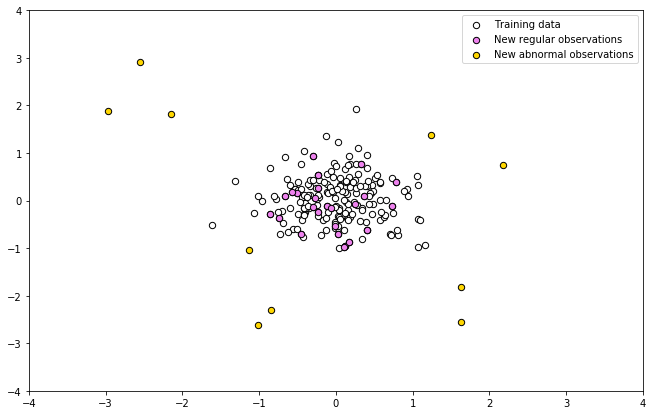

In [139]:
# plot
fig, ax = plt.subplots(figsize=(11,7))
plot_new_observations(X_train, X_new, anomaly, ax)

In [140]:
y_new = model.predict(X_new)
y_anomaly = model.predict(anomaly)
y_new, y_anomaly

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1]), array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]))

In [141]:
err_new = y_new[y_new == -1].size
err_anomaly = y_anomaly[y_anomaly == -1].size
err_new, err_anomaly

(0, 10)

In [142]:
print("Fraction of new regular observations misclassified = {}/{}".format(err_new, new_observation))
print("Fraction of new abnormal observations correctly classified = {}/{}".format(err_anomaly, new_anomaly))

Fraction of new regular observations misclassified = 0/25
Fraction of new abnormal observations correctly classified = 10/10


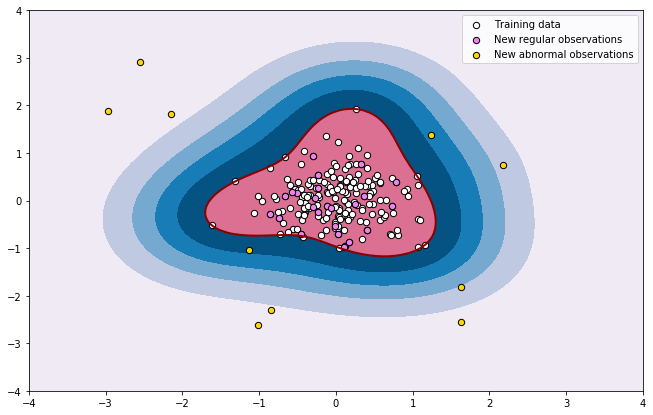

In [143]:
fig, ax = plt.subplots(figsize=(11,7))

# plot the decision function
plot_decision_function(model, ax, sv=False)
plot_new_observations(X_train, X_new, anomaly, ax)

In [144]:
# generate two cluster for the training 
np.random.seed(42)
X_train1 = 0.5 * np.random.randn(n_points//2, 2)+1.5
X_train2 = 0.5 * np.random.randn(n_points//2, 2)-1.5
X_train1, X_train2

(array([[1.74835708, 1.43086785],
        [1.82384427, 2.26151493],
        [1.38292331, 1.38293152],
        [2.28960641, 1.88371736],
        [1.26526281, 1.77128002],
        [1.26829115, 1.26713512],
        [1.62098114, 0.54335988],
        [0.63754108, 1.21885624],
        [0.99358444, 1.65712367],
        [1.04598796, 0.79384815],
        [2.23282438, 1.38711185],
        [1.5337641 , 0.78762591],
        [1.22780864, 1.55546129],
        [0.92450321, 1.68784901],
        [1.19968066, 1.35415313],
        [1.19914669, 2.42613909],
        [1.49325139, 0.97114454],
        [1.91127246, 0.88957818],
        [1.6044318 , 0.52016494],
        [0.83590698, 1.59843062],
        [1.86923329, 1.58568414],
        [1.44217586, 1.34944815],
        [0.760739  , 1.1400779 ],
        [1.26968061, 2.02856111],
        [1.67180914, 0.61847992],
        [1.66204198, 1.30745886],
        [1.161539  , 1.80583814],
        [2.01549976, 1.96564006],
        [1.08039124, 1.34539381],
        [1.665

In [145]:
X_train = np.r_[X_train1, X_train2]
X_train

array([[ 1.74835708,  1.43086785],
       [ 1.82384427,  2.26151493],
       [ 1.38292331,  1.38293152],
       [ 2.28960641,  1.88371736],
       [ 1.26526281,  1.77128002],
       [ 1.26829115,  1.26713512],
       [ 1.62098114,  0.54335988],
       [ 0.63754108,  1.21885624],
       [ 0.99358444,  1.65712367],
       [ 1.04598796,  0.79384815],
       [ 2.23282438,  1.38711185],
       [ 1.5337641 ,  0.78762591],
       [ 1.22780864,  1.55546129],
       [ 0.92450321,  1.68784901],
       [ 1.19968066,  1.35415313],
       [ 1.19914669,  2.42613909],
       [ 1.49325139,  0.97114454],
       [ 1.91127246,  0.88957818],
       [ 1.6044318 ,  0.52016494],
       [ 0.83590698,  1.59843062],
       [ 1.86923329,  1.58568414],
       [ 1.44217586,  1.34944815],
       [ 0.760739  ,  1.1400779 ],
       [ 1.26968061,  2.02856111],
       [ 1.67180914,  0.61847992],
       [ 1.66204198,  1.30745886],
       [ 1.161539  ,  1.80583814],
       [ 2.01549976,  1.96564006],
       [ 1.08039124,

In [146]:
X_train.shape

(200, 2)

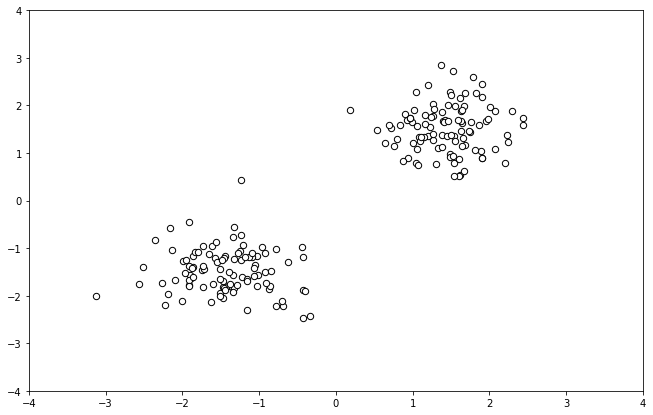

In [147]:
# plot
fig, ax = plt.subplots(figsize=(11,7))
_ = plt.scatter(X_train[:,0], X_train[:,1], axes=ax, color='w', s=40, edgecolors='k')
_ = ax.set_xlim([-4, 4])
_ = ax.set_ylim([-4, 4])

In [148]:
model = svm.OneClassSVM(nu=0.06, kernel="rbf", gamma=0.5)
model.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.5, kernel='rbf',
      max_iter=-1, nu=0.06, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

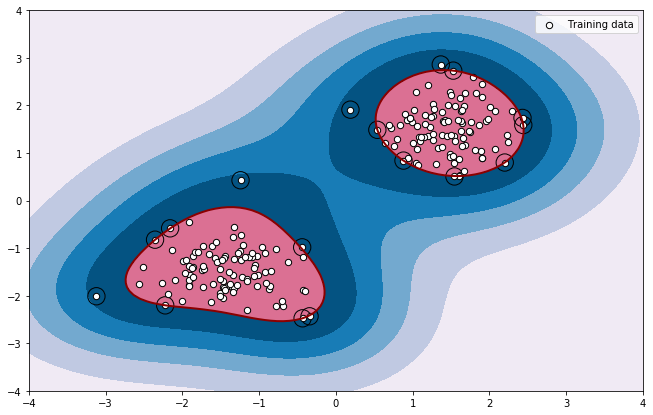

In [149]:
fig, ax = plt.subplots(figsize=(11,7))
# plot the decision function
plot_decision_function(model, ax, sv=True)
# add the training points
_ = plt.scatter(X_train[:,0], X_train[:,1], axes=ax,
                color='w', s=40, edgecolors='k',label='Training data')
_ = ax.legend()

In [150]:
# compute the empirical error 
y_train = model.predict(X_train)
err_emp_1 = y_train[y_train == -1].size
print("Training error = {}/{}".format(err_emp_1, n_points))

Training error = 13/200


In [151]:
new_observation = 50
new_anomaly = 20

# generate new observation from the same distribution
np.random.seed(42)
X_new_1 = 0.5 * np.random.randn(new_observation//2, 2)+1.5
X_new_2 = 0.5 * np.random.randn(new_observation//2, 2)-1.5
X_new = np.r_[X_new_1, X_new_2]

# generate outliers
anomaly = np.random.uniform(low=-4, high=4, size=(new_anomaly, 2))

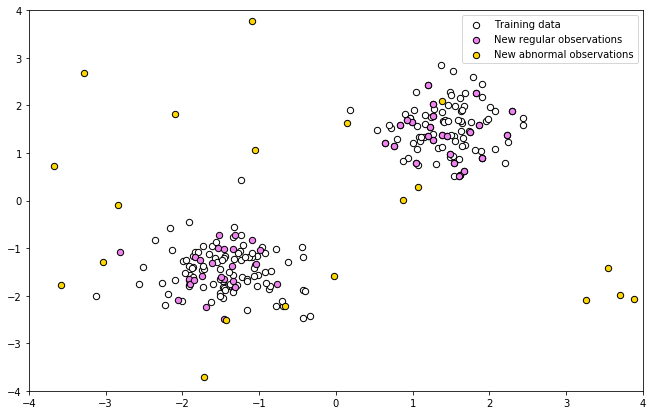

In [152]:
# plot
fig, ax = plt.subplots(figsize=(11,7))
plot_new_observations(X_train, X_new, anomaly, ax)

In [153]:
y_new = model.predict(X_new)
y_anomaly = model.predict(anomaly)

In [154]:
err_new = y_new[y_new == -1].size
err_anomaly = y_anomaly[y_anomaly == -1].size

In [155]:
print("Fraction of new regular observations misclassified = {}/{}".format(err_new, new_observation))
print("Fraction of new abnormal observations correctly classified = {}/{}".format(err_anomaly, new_anomaly))

Fraction of new regular observations misclassified = 2/50
Fraction of new abnormal observations correctly classified = 18/20


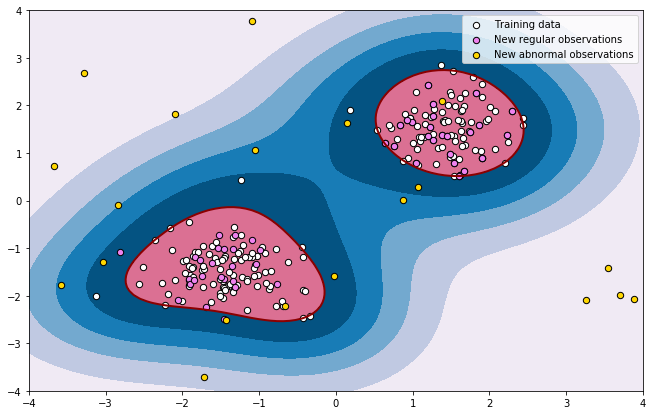

In [156]:
fig, ax = plt.subplots(figsize=(11,7))

# plot the decision function
plot_decision_function(model, ax, sv=False)
plot_new_observations(X_train, X_new, anomaly, ax)

In [157]:
# We can try to move the cluster closer

np.random.seed(42)
X_train1 = 0.5 * np.random.randn(n_points//2, 2)+0.9
X_train2 = 0.5 * np.random.randn(n_points//2, 2)-0.9

X_train = np.r_[X_train1, X_train2]

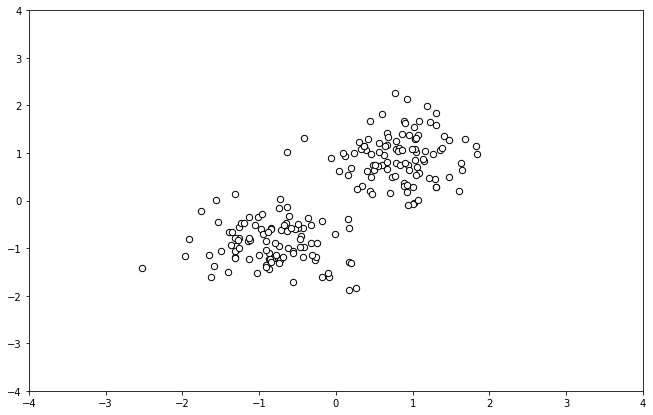

In [158]:
# plot
fig, ax = plt.subplots(figsize=(11,7))
_ = plt.scatter(X_train[:,0], X_train[:,1], axes=ax, color='w', s=40, edgecolors='k')
_ = ax.set_xlim([-4, 4])
_ = ax.set_ylim([-4, 4])


In [159]:
model = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
model.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
      max_iter=-1, nu=0.05, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

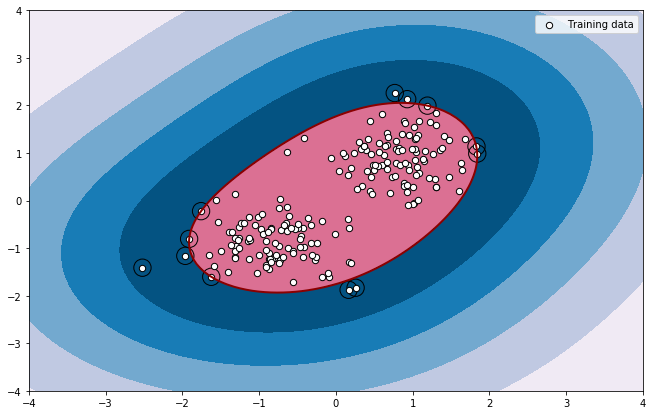

In [160]:
fig, ax = plt.subplots(figsize=(11,7))

# plot the decision function
plot_decision_function(model, ax, sv=True)
# add the training points
_ = plt.scatter(X_train[:,0], X_train[:,1], axes=ax,
                color='w', s=40, edgecolors='k',label='Training data')
_ = ax.legend()

In [161]:
# compute the empirical error 
y_train = model.predict(X_train)
err_emp_1 = y_train[y_train == -1].size
print("Training error = {}/{}".format(err_emp_1, n_points))

Training error = 9/200


In [162]:
model = svm.OneClassSVM(nu=0.3, kernel="rbf", gamma=1)
model.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=1, kernel='rbf',
      max_iter=-1, nu=0.3, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

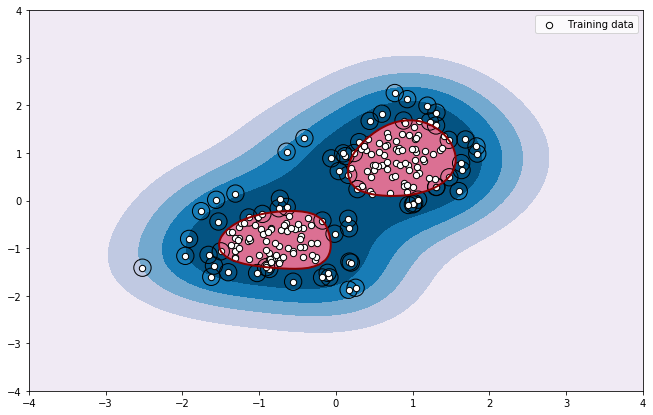

In [163]:
fig, ax = plt.subplots(figsize=(11,7))

# plot the decision function
plot_decision_function(model, ax, sv=True)

# add the training points
_ = plt.scatter(X_train[:,0], X_train[:,1], axes=ax,
                color='w', s=40, edgecolors='k',label='Training data')
_ = ax.legend()

In [164]:
# compute the empirical error 
y_train = model.predict(X_train)
err_emp_1 = y_train[y_train == -1].size
print("Training error = {}/{}".format(err_emp_1, n_points))

Training error = 60/200


Seems like the values for V1, V2, etc are on average much farther from 0 for fraud.

Let's check out some correlations matrices

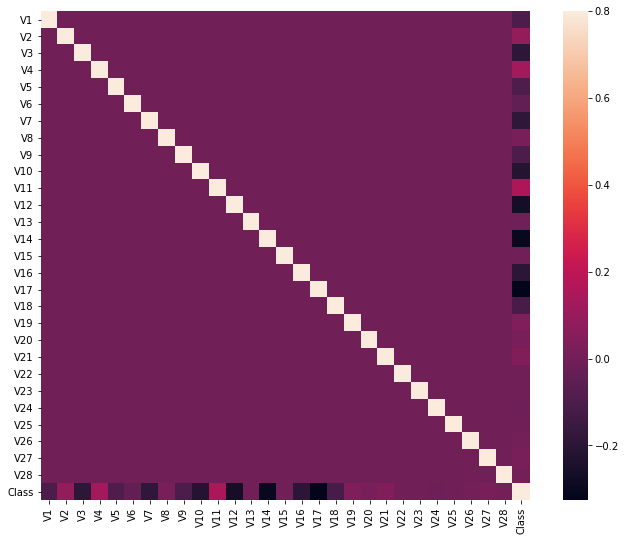

In [165]:
#correlation matrix
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(data.drop(['Amount','Time'],1).corr(), vmax=.8, square=True);

* Class correlates most with V1 - V18 and not (or barely) with V19 - V28

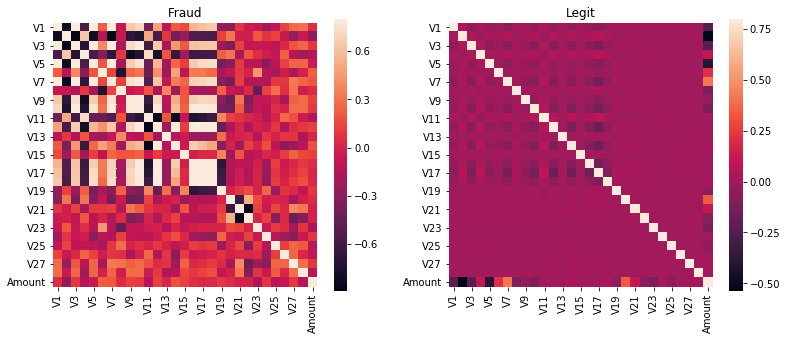

In [166]:
#correlation matrix for only Fraud
f, (ax1, ax2) = plt.subplots(1,2,figsize=(13, 5))
sns.heatmap(data.query("Class==1").drop(['Class','Time'],1).corr(), vmax=.8, square=True, ax=ax1)
ax1.set_title('Fraud')
sns.heatmap(data.query("Class==0").drop(['Class','Time'],1).corr(), vmax=.8, square=True, ax=ax2);
ax2.set_title('Legit')
plt.show()

* Strong correlations between the different V for Fraud data
* Much less correlation for Legit data
* Correlation between the data seems to be an important key (This should be captured by Multivariate Gaussian)
* Seems like Amount correlates as well. Thus, I should perhaps include it...


#### Check out some distributions
They should ideally be gaussian for non-fraud examples

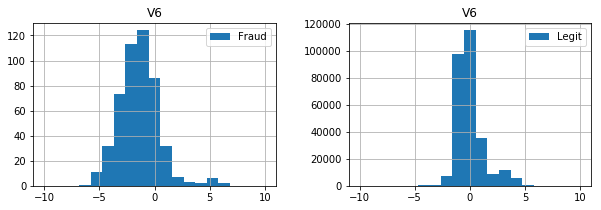

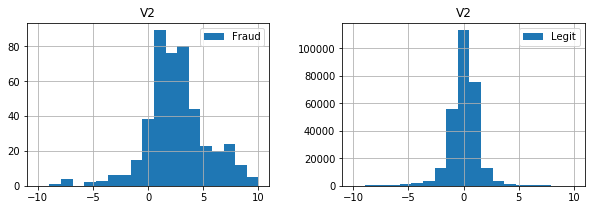

In [167]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3))
data.query("Class==1").hist(column='V6',bins=np.linspace(-10,10,20),ax=ax1,label='Fraud')
ax1.legend()
data.query("Class==0").hist(column='V6',bins=np.linspace(-10,10,20),ax=ax2,label='Legit')
plt.legend()
plt.show()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3))
data.query("Class==1").hist(column='V2',bins=np.linspace(-10,10,20),ax=ax1,label='Fraud')
ax1.legend()
data.query("Class==0").hist(column='V2',bins=np.linspace(-10,10,20),ax=ax2,label='Legit')
plt.legend()
plt.show()

(try it for different Vi)

For Legit transactions, the Vi are centered around 0 and look kind of gaussian. For frauds, they are off-center

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab346ffd68>]],
      dtype=object)

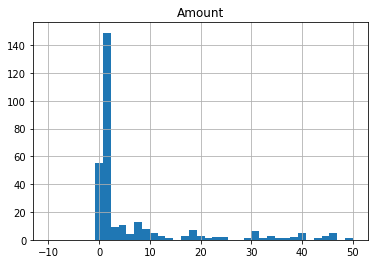

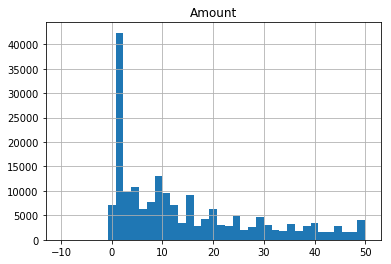

In [168]:
bins=np.linspace(-10,50,40)
data.query("Class==1").hist(column='Amount',bins=bins)
data.query("Class==0").hist(column="Amount",bins=bins)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab3493fda0>]],
      dtype=object)

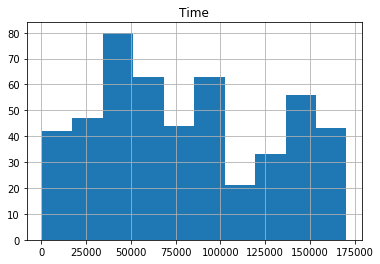

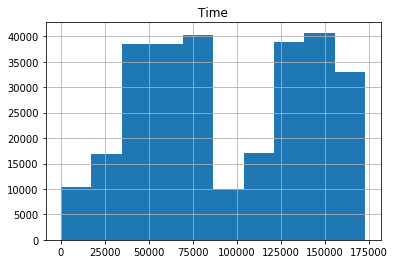

In [169]:
data.query("Class==1").hist(column="Time")#,bins=np.linspace(-10,10,20))
data.query("Class==0").hist(column="Time")#,bins=np.linspace(-10,10,20))

* **TIME** makes no difference apparently
* **AMOUNT** hard to say... Does not really look like a gaussian. Frauds seem to have a tendency for low amounts.

### For now drop "Amount"

In [170]:
X_Legit = data.query("Class==0").drop(["Amount","Class","Time"],1)
y_Legit = data.query("Class==0")["Class"]

X_Fraud = data.query("Class==1").drop(["Amount","Class","Time"],1)
y_Fraud = data.query("Class==1")["Class"]

#split data into training and cv set
X_train, X_test, y_train, y_test = train_test_split(X_Legit, y_Legit, test_size=0.33, random_state=42)
print(len(X_test))
X_test = X_test.append(X_Fraud)
print(len(X_Fraud),'   ', len(X_test))
y_test = y_test.append(y_Fraud)
X_test.head()

93824
492     94316


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
138028,1.314539,0.590643,-0.666593,0.716564,0.301978,-1.125467,0.388881,-0.288390,-0.132137,-0.597739,-0.325347,-0.216435,0.084204,-1.054631,0.967932,0.601226,0.631117,0.295078,-0.136151,-0.058040,-0.170307,-0.429655,-0.141341,-0.200195,0.639491,0.399476,-0.034321,0.031692
63099,-0.798672,1.185093,0.904547,0.694584,0.219041,-0.319295,0.495236,0.139269,-0.760214,0.170547,0.821998,0.468322,-0.057550,0.573006,0.358688,-0.011633,-0.504570,0.722750,0.861541,-0.081298,0.202287,0.578699,-0.092245,0.013723,-0.246466,-0.380057,-0.396030,-0.112901
73411,-0.391128,-0.245540,1.122074,-1.308725,-0.639891,0.008678,-0.701304,-0.027315,-2.628854,2.051312,0.575866,-0.594037,1.097880,-0.338340,0.617523,-0.756390,0.535141,1.016704,2.133828,0.065716,-0.133485,0.117403,-0.191748,-0.488642,-0.309774,0.008100,0.163716,0.239582
164247,-0.060302,1.065093,-0.987421,-0.029567,0.176376,-1.348539,0.775644,0.134843,-0.149734,-1.238598,-0.841133,-0.586472,-0.779620,-0.436671,0.747871,0.266437,0.703234,0.916719,-0.189967,-0.169706,0.355576,0.907570,-0.018454,-0.126269,-0.339923,-0.150285,-0.023634,0.042330
148999,1.848433,0.373364,0.269272,3.866438,0.088062,0.970447,-0.721945,0.235983,0.683491,1.166335,1.297531,-1.920966,1.885047,1.323225,-2.044482,1.317655,-0.441076,0.804104,-1.658339,-0.282777,0.103563,0.620954,0.197077,0.692392,-0.206530,-0.021328,-0.019823,-0.042682


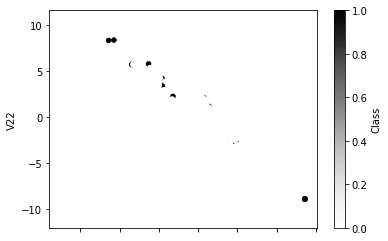

In [171]:
data.plot.scatter("V21","V22",c="Class")

V22 and V21 are definitely anticorrelated. The distribution looks like a Gaussian.

### Multivariate Gaussian
OneClassSVM is further below

In [172]:
# Write my own Multivariate Gaussian outlier detection
X = X_train
m = len(X)
mu = 1./m * X.mean()
Sigma=0
for i in range(m):
    Sigma += np.outer((X.iloc[i]-mu) , (X.iloc[i]-mu))
Sigma*=1./m
Sig_inv = np.linalg.inv(Sigma)
Sig_det = np.linalg.det(Sigma)

In [173]:
np.matrix(Sigma).shape

(28, 28)

In [174]:
# This function calculates the probability for a Gaussian distribution
def prob(x_example):
    n=len(Sigma)
    xminusmu = x_example - mu
    return 1./((2*np.pi)**(n/2.) * Sig_det**0.5) * np.exp(-0.5* xminusmu.dot(Sig_inv).dot(xminusmu))

In [175]:
Sigma.diagonal()

array([3.73862918, 2.69433813, 2.13845919, 1.96249287, 1.81723591,
       1.75740003, 1.35723629, 1.32956165, 1.18401463, 1.09365716,
       1.00572355, 0.897544  , 0.99009349, 0.8067305 , 0.836429  ,
       0.71701652, 0.56649001, 0.67877288, 0.66132045, 0.58784433,
       0.50218947, 0.52359849, 0.39242964, 0.3668837 , 0.27135014,
       0.23248764, 0.15853814, 0.11726636])

In [176]:
# Check out some resulting probablilities for Fraud examples
for i in range(10):
    print(prob(X_Fraud.iloc[i]))

1.9654598175316857e-97
6.057665732208794e-19
2.936927183952521e-103
0.0
1.625805677865642e-60
8.837233447830389e-299
2.1761894009765954e-298
3.2993486531098596e-180
2.7964352624385633e-179
7.447360473789997e-273


In [177]:
# Check out some resulting probablilities for NON-Fraud examples
for i in range(10):
    print(prob(X_train.iloc[i]))

2.6528574453465834e-12
5.786459536421419e-13
1.6333155126245454e-19
2.0885590632599637e-12
2.1349517632692612e-17
2.256126030796635e-13
1.6846007295596435e-15
5.475252814467613e-19
5.884470488058433e-13
3.167097582880798e-12


In [178]:
# Picking out 100 training examples to test how many are misclassified as false positive
ptrain_result = np.apply_along_axis(prob, 1, X_train.head(100))

In [179]:
sum(ptrain_result < 1e-13)

49

With an epsilon of 1e-13, roughly 50% of the test samples are falsely classified as Fraud. Let's see how many are classified correctly using that epsilon

In [180]:
# Copying this to a variable with a new name because i am using the same 
# variable below with 'Amount' included as feature
pTest_result = np.apply_along_axis(prob, 1, X_test)
pTest_result_prev = np.copy(pTest_result)

In [181]:
epsilon = 1e-13
yTest_result_prev = (pTest_result_prev < epsilon)

In [182]:
tp = sum(yTest_result_prev  & y_test)
tn = sum((~ yTest_result_prev)  & (~ y_test))
fp = sum((yTest_result_prev)  & (~ y_test))
fn = sum((~ yTest_result_prev)  & ( y_test))

print("true_pos ",tp)
print("true_neg ",tn)
print("false_pos ",fp)
print("false_neg ",fn)

recall = tp / (tp + fn)
precision = tp / (tp + fp)
F1 = 2*recall*precision/(recall+precision)
print("recall=",recall,"\nprecision=",precision)
print("F1=",F1)

true_pos  479
true_neg  43451
false_pos  50373
false_neg  13
recall= 0.9735772357723578 
precision= 0.009419491858727288
F1= 0.018658460579619823


Thus, I obtain a recall of 97%, but a low precision of 0.01, which means only 1 out of 100 fraud 'detections' are actual frauds

#### rescale "Amount" and use it


In [183]:
data["Amountresc"] = (data["Amount"])/data["Amount"].var()

X_Legit = data.query("Class==0").drop(["Amount","Class","Time"],1)
y_Legit = data.query("Class==0")["Class"]

X_Fraud = data.query("Class==1").drop(["Amount","Class","Time"],1)
y_Fraud = data.query("Class==1")["Class"]

#split data into training and cv set
X_train, X_test, y_train, y_test = train_test_split(X_Legit, y_Legit, test_size=0.33, random_state=42)
X_test = X_test.append(X_Fraud)
y_test = y_test.append(y_Fraud)
X_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amountresc
138028,1.314539,0.590643,-0.666593,0.716564,0.301978,-1.125467,0.388881,-0.288390,-0.132137,-0.597739,-0.325347,-0.216435,0.084204,-1.054631,0.967932,0.601226,0.631117,0.295078,-0.136151,-0.058040,-0.170307,-0.429655,-0.141341,-0.200195,0.639491,0.399476,-0.034321,0.031692,0.000012
63099,-0.798672,1.185093,0.904547,0.694584,0.219041,-0.319295,0.495236,0.139269,-0.760214,0.170547,0.821998,0.468322,-0.057550,0.573006,0.358688,-0.011633,-0.504570,0.722750,0.861541,-0.081298,0.202287,0.578699,-0.092245,0.013723,-0.246466,-0.380057,-0.396030,-0.112901,0.000067
73411,-0.391128,-0.245540,1.122074,-1.308725,-0.639891,0.008678,-0.701304,-0.027315,-2.628854,2.051312,0.575866,-0.594037,1.097880,-0.338340,0.617523,-0.756390,0.535141,1.016704,2.133828,0.065716,-0.133485,0.117403,-0.191748,-0.488642,-0.309774,0.008100,0.163716,0.239582,0.000240
164247,-0.060302,1.065093,-0.987421,-0.029567,0.176376,-1.348539,0.775644,0.134843,-0.149734,-1.238598,-0.841133,-0.586472,-0.779620,-0.436671,0.747871,0.266437,0.703234,0.916719,-0.189967,-0.169706,0.355576,0.907570,-0.018454,-0.126269,-0.339923,-0.150285,-0.023634,0.042330,0.000911
148999,1.848433,0.373364,0.269272,3.866438,0.088062,0.970447,-0.721945,0.235983,0.683491,1.166335,1.297531,-1.920966,1.885047,1.323225,-2.044482,1.317655,-0.441076,0.804104,-1.658339,-0.282777,0.103563,0.620954,0.197077,0.692392,-0.206530,-0.021328,-0.019823,-0.042682,0.000000


In [184]:
# Use my outlier detection
X = X_train
m = len(X)
mu = 1./m * X.mean()
Sigma=0
for i in range(m):
    Sigma += np.outer((X.iloc[i]-mu) , (X.iloc[i]-mu))
Sigma*=1./m
Sig_inv = np.linalg.inv(Sigma)
Sig_det = np.linalg.det(Sigma)

In [185]:
pTest_result = np.apply_along_axis(prob, 1, X_test)

In [186]:
epsilon = 2e-11
yTest_result = (pTest_result < epsilon)

tp = sum(yTest_result  & y_test)
tn = sum((~ yTest_result)  & (~ y_test))
fp = sum((yTest_result)  & (~ y_test))
fn = sum((~ yTest_result)  & ( y_test))

print("true_pos ",tp)
print("true_neg ",tn)
print("false_pos ",fp)
print("false_neg ",fn)

recall = tp / (tp + fn)
precision = tp / (tp + fp)
F1 = 2*recall*precision/(recall+precision)
print("recall=",recall,"\nprecision=",precision)
print("F1=",F1)

true_pos  479
true_neg  41984
false_pos  51840
false_neg  13
recall= 0.9735772357723578 
precision= 0.009155373764789082
F1= 0.018140160193899


### Conclusion
No real improvement. Note, that I am using a larger epsilon



### Next up
I can try the Novelty Detection algorithm by scikit

In [187]:
len(X_train)

190491

In [188]:
## Use only part of training set, otherwise it takes very long
Xsmall = X_train.head(20000)

In [189]:
# fit the model
clf = svm.OneClassSVM(kernel="rbf", nu=0.01, gamma=0.3)
clf.fit(Xsmall)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.3, kernel='rbf',
      max_iter=-1, nu=0.01, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [190]:
y_pred_test = clf.predict(X_test)
y_pred_test = np.array([y==-1 for y in y_pred_test])

tp = sum(y_pred_test  & y_test)
tn = sum((~ y_pred_test)  & (~ y_test))
fp = sum((y_pred_test)  & (~ y_test))
fn = sum((~ y_pred_test)  & ( y_test))


print("true_pos ",tp)
print("true_neg ",tn)
print("false_pos ",fp)
print("false_neg ",fn)

recall = tp / (tp + fn)
precision = tp / (tp + fp)
F1 = 2*recall*precision/(recall+precision)
print("recall=",recall,"\nprecision=",precision)
print("F1=",F1)

true_pos  478
true_neg  56244
false_pos  37580
false_neg  14
recall= 0.9715447154471545 
precision= 0.012559777182195597
F1= 0.024798962386511025


In [191]:
# ## Some results from different test runs
# # nu=0.01, gamma=0.3
# true_pos  478
# true_neg  55794
# false_pos  38030
# false_neg  14
# recall= 0.971544715447 
# precision= 0.0124130050899
# F1= 0.0245128205128

# # nu=0.05, gamma=0.3
# true_pos  478
# true_neg  55774
# false_pos  38050
# false_neg  14
# recall= 0.971544715447 
# precision= 0.0124065614618
# F1= 0.0245002562788

# # nu=0.05, gamma=0.2
# true_pos  463
# true_neg  68954
# false_pos  24870
# false_neg  29
# recall= 0.941056910569 
# precision= 0.0182765562705
# F1= 0.0358567279768

# # nu=0.5, gamma=0.5
# true_pos  487
# true_neg  36001
# false_pos  57823
# false_neg  5
# recall= 0.989837398374 
# precision= 0.00835191219345
# F1= 0.0165640624469

# # nu=0.5, gamma=0.1
# true_pos  478
# true_neg  47316
# false_pos  46508
# false_neg  14
# recall= 0.971544715447 
# precision= 0.0101732430937
# F1= 0.0201356417709

- With nu=0.5, gamma=0.1:  97% of frauds are detected, but only 1 in 100 detections is actual fraud (i.e. 99% false alert). Seems fine to me... But: It's not better than Multivariate Gaussian (but much slower).
- with a smaller nu we get larger F1 and higher precision BUT smaller recall...
- Same thing goes for gamma... Larger gamma means larger recall and smaller precision. 
- TODO: Plot precision, recall and F1 as a function of mu and gamma.
- TODO (?): Add new features V1xV3, V1xV5, V1xV7 to make use of the strong correlation between the two for fraud detection and see if it improves results. For multivariate Gaussian, the correlations should already be included. I am not sure if this is also the case for OneClass SVM with a Gaussian Kernel...

### Try another classification algorithm - IsolationForest

In [192]:
from sklearn.ensemble import IsolationForest
rng = np.random.RandomState(42)


clf = IsolationForest(max_samples=10, random_state=rng)
clf.fit(X_train.head(100000))
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
#y_pred_outliers = clf.predict(X_outliers)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:158: DeprecationWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  DeprecationWarning)


In [193]:
y_pred_test = clf.predict(X_test)
y_pred_test = np.array([y==-1 for y in y_pred_test])

tp = sum(y_pred_test  & y_test)
tn = sum((~ y_pred_test)  & (~ y_test))
fp = sum((y_pred_test)  & (~ y_test))
fn = sum((~ y_pred_test)  & ( y_test))


print("true_pos ",tp)
print("true_neg ",tn)
print("false_pos ",fp)
print("false_neg ",fn)

recall = tp / (tp + fn)
precision = tp / (tp + fp)
F1 = 2*recall*precision/(recall+precision)
print("recall=",recall,"\nprecision=",precision)
print("F1=",F1)

true_pos  418
true_neg  84420
false_pos  9404
false_neg  74
recall= 0.8495934959349594 
precision= 0.04255752392588068
F1= 0.0810548768663952


This does not look very promising and I know too little about Random Forest... 

In fact, isolation forest seems to be for outlier detection, not for novely detection (http://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection). So maybe it's not that useful here